In [1]:
import arviz as az
import bambi as bmb
import kulprit as kpt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import preliz as pz
import pymc as pm
from scipy.interpolate import PchipInterpolator
from scipy.stats import linregress
import xarray as xr

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# 1. 
En la siguiente definición de modelo probabilístico cual es el likelihood, cual es el a priori y cual el a posteriori?

$$
y_i \sim Normal(\mu, \sigma)
$$
$$
\mu \sim Normal(0, 10)  
$$
$$
\sigma \sim HalfNormal(25)  
$$

La _likelihood_ es la probabilidad de los datos dado el modelo $p(y_i | \mu, \sigma)$, en este caso: $Likelihood \sim Normal(\mu, \sigma)$.  
Las distribuciones a priori de los parámetros serían $\mu \sim Normal(0, 10)$ y $\sigma \sim HalfNormal(25)$.  
La distribución _a posteriori_ es la probabilidad del modelo dado los datos $p(\mu, \sigma) = \frac{p(y_i | \mu, \sigma)p(\mu)p(\sigma)}{p(y_i)}$, en este caso creo que se puede calcular y da una Normal para $\mu$ al menos (HACER) 

# 2.
En el modelo del punto 1 ¿cuántos parámetros hay en el posterior? o expresado de otra forma ¿cuántas dimensiones tiene el a posteriori?

El _posterior_ es una distribución de dos dimensiones, una por parámetro.  
Sería la conjunta de las posteriors de $\mu$ y $\sigma$

# 4.
Usando el conjunto de datos ``howell`` (disponible junto con esta notebook) realice un modelo lineal del peso ($x$) versus la altura ($y$). Excluya a los menores de 18 años. Exponga los resultados.

In [2]:
howell = pd.read_csv('../datos/howell.csv', sep=';')

howell.head()

,altura,peso,edad,sexo
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [3]:
howell = howell[howell['edad'] >= 18]

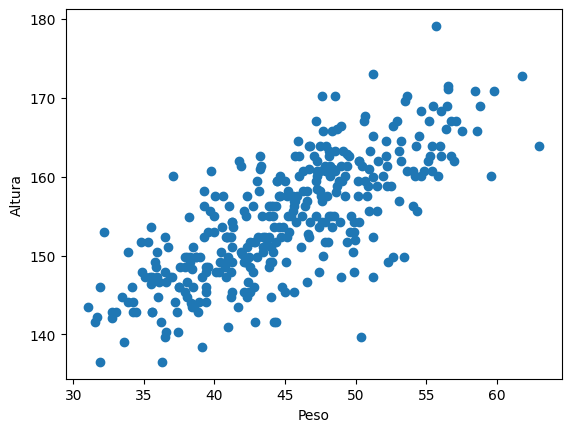

In [4]:
plt.scatter(howell['peso'], howell['altura'])
plt.xlabel('Peso')
plt.ylabel('Altura');

In [8]:
with pm.Model() as modelo_howell:
    intercepto = pm.Normal('intercepto', mu=0, sigma=10)
    pendiente = pm.Normal('pendiente', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=10)

    mu = pm.Deterministic('mu', intercepto + pendiente * howell['peso'])
    
    altura = pm.Normal('altura', mu=mu, sigma=sigma, observed=howell['altura'])

In [9]:
with modelo_howell:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercepto, pendiente, sigma]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


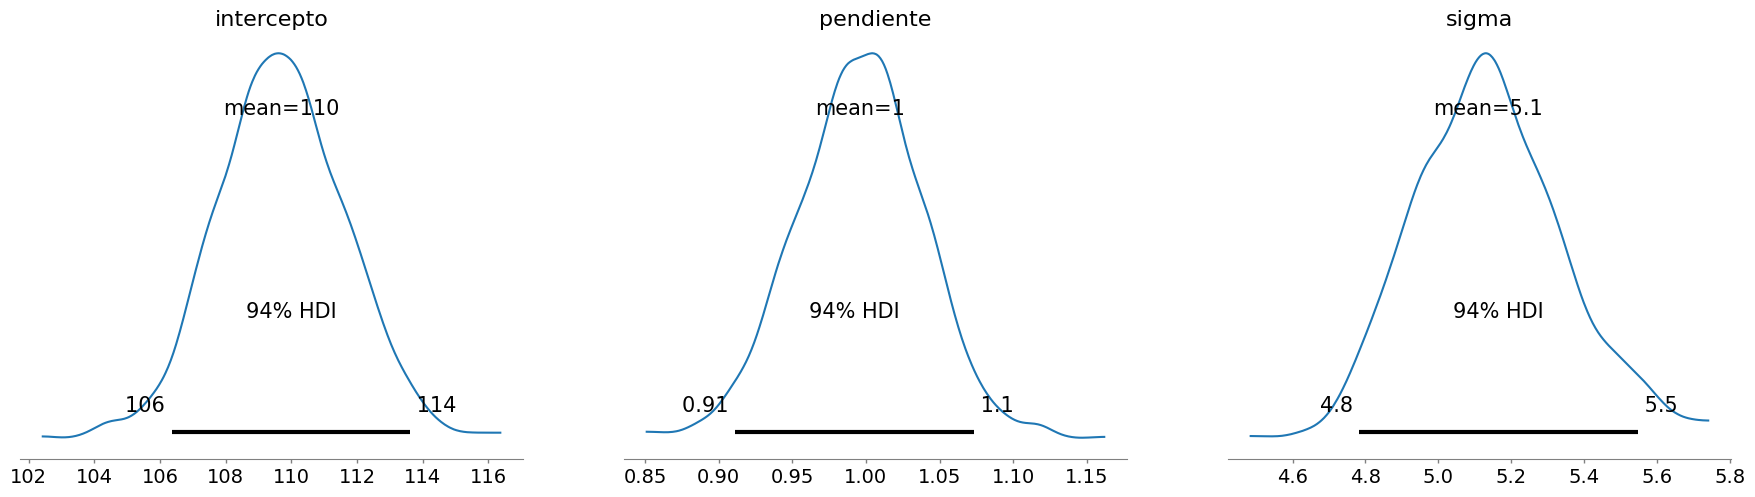

In [10]:
az.plot_posterior(idata, var_names=['intercepto', 'pendiente', 'sigma']);

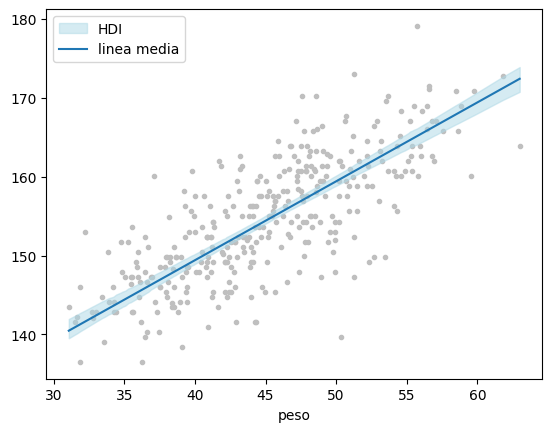

In [18]:
posterior = az.extract(idata, num_samples=50)
x_plot = xr.DataArray(np.linspace(howell.peso.min(), howell.peso.max(), 50), dims="plot_id")
linea_media = posterior['intercepto'].mean() + posterior['pendiente'].mean() * x_plot
hdi_lines = az.hdi(idata.posterior['mu'])


plt.plot(howell.peso, howell.altura, '.', color="0.75",  zorder=-3)
idx = np.argsort(howell.peso.values)
plt.fill_between(howell.peso.sort_values(), hdi_lines["mu"][:,0][idx], hdi_lines["mu"][:,1][idx],
                     color="lightblue", label='HDI', alpha=0.5)
plt.plot(x_plot, linea_media, c='C0', label='linea media')
plt.xlabel('peso')
plt.legend();

In [19]:
pm.sample_posterior_predictive(idata, model=modelo_howell, extend_inferencedata=True)

Sampling: [altura]


Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

No pude correr el codigo para graficar la posterior predictive

### con bambi

In [4]:
modelo_lineal = bmb.Model("altura ~ peso", howell)

In [5]:
modelo_lineal

       Formula: altura ~ peso
        Family: gaussian
          Link: mu = identity
  Observations: 352
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 154.5971, sigma: 136.2498)
            peso ~ Normal(mu: 0.0, sigma: 2.9978)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 7.7313)

In [6]:
idata = modelo_lineal.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [altura_sigma, Intercept, peso]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 20 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


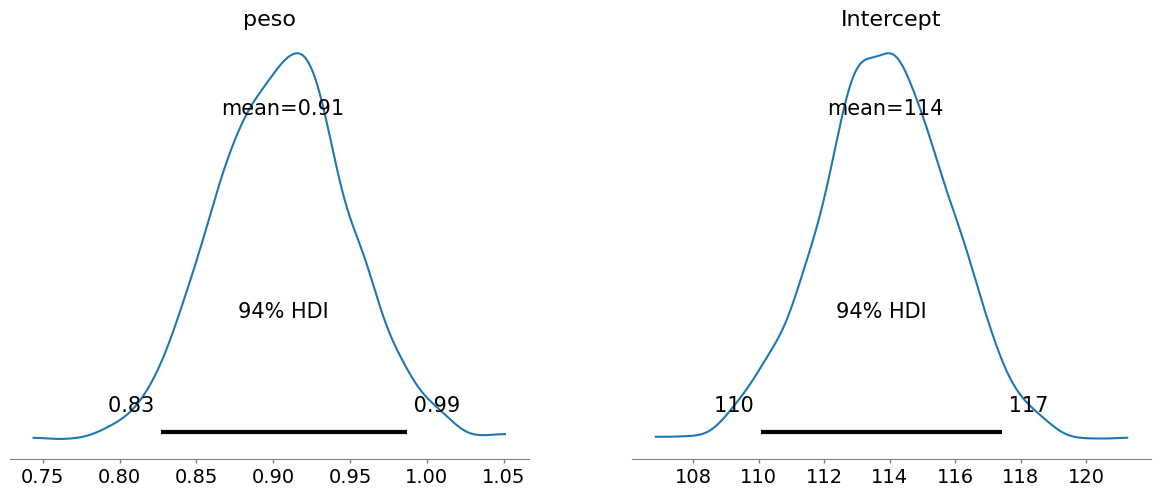

In [10]:
az.plot_posterior(idata, var_names=['peso', 'Intercept']);

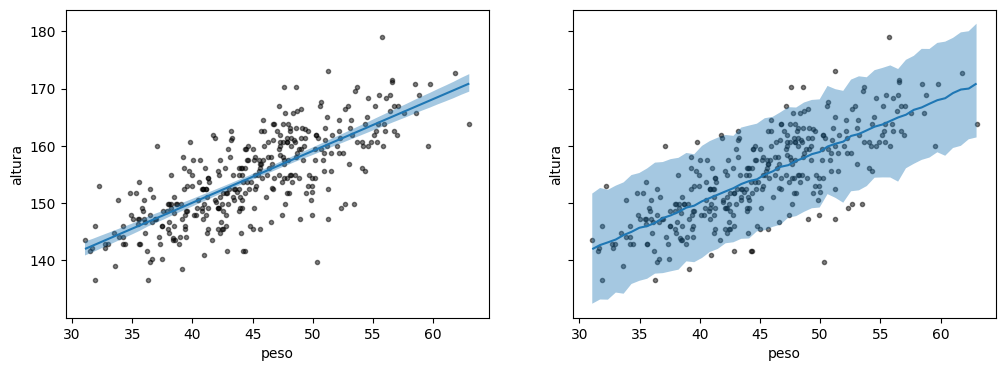

In [36]:
_, axes = plt.subplots(1, 2, sharey=True, figsize=(12, 4))
bmb.interpret.plot_predictions(modelo_lineal, idata, 'peso', ax=axes[0])
bmb.interpret.plot_predictions(modelo_lineal, idata, 'peso', pps=True, ax=axes[1])

axes[0].plot(howell['peso'], howell['altura'], '.', color='black', alpha=0.5, zorder=-1)
axes[1].plot(howell['peso'], howell['altura'], '.', color='black', alpha=0.5, zorder=-1);

# 5. 
Para 4 individuos se registraron los pesos (45.73, 65.8, 54.2, 32.59), pero no las alturas. Usando el modelo del punto anterior prediga la altura esperada para cada individuo junto con un intervalo de credibilidad del 50% y del 89%.

No entiendo bien si hay que calcular el peso esperado con los posteriors de los parametros o usar la posterior predictive.

En caso de ser la primera opción:

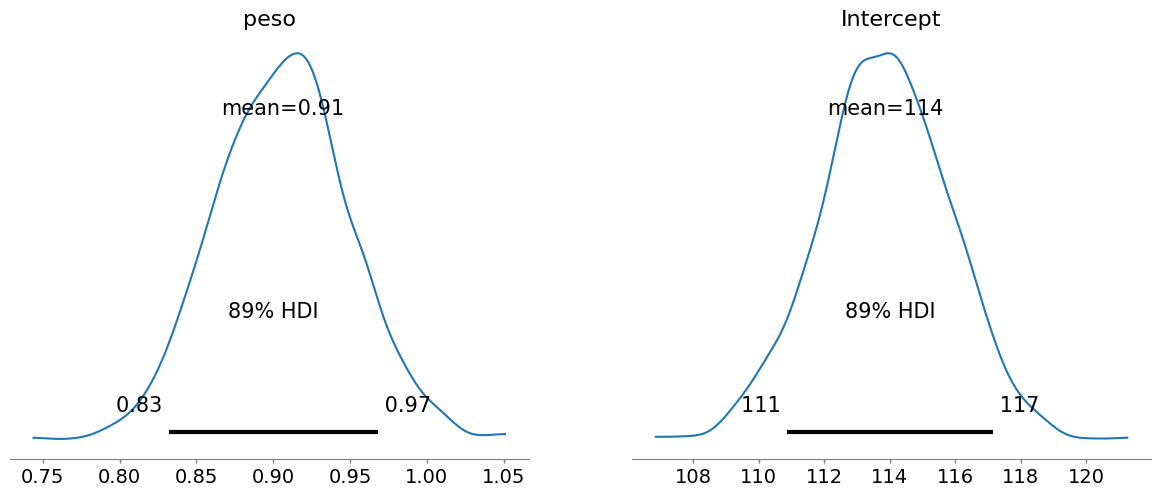

In [11]:
az.plot_posterior(idata, var_names=['peso', 'Intercept'], hdi_prob=0.89);

De este gráfico puedo sacar que el peso esperado va a ser $114 + 0.91x$ para cada $x \in$ ``[45.73, 65.8, 54.2, 32.59]`` y que estoy un 89% seguro que el peso $\in (111 + 0.83x, 117 + 0.97x)$. Y falta agregar la incertidumbre que da $\sigma$.  
Algo similar para el hdi 50%

La otra opción era usar la _posterior predictive_

In [74]:
pesos = [45.73, 65.8, 54.2, 32.59]
df_pesos = pd.DataFrame({'peso': pesos})

In [46]:
modelo_lineal.predict(idata, data=df_pesos, kind='pps')

Puedo mirar el ``summary`` para ver una representación númerica de los resultados buscados.

In [89]:
az.summary(idata, hdi_prob=0.89, kind='stats').tail(4)

,mean,sd,hdi_5.5%,hdi_94.5%
altura_mean[0],155.269,0.278,154.841,155.717
altura_mean[1],173.409,0.946,171.935,174.934
altura_mean[2],162.924,0.488,162.160,163.722
altura_mean[3],143.392,0.600,142.472,144.363


In [90]:
az.summary(idata, hdi_prob=0.50, kind='stats').tail(4)

,mean,sd,hdi_25%,hdi_75%
altura_mean[0],155.269,0.278,155.103,155.470
altura_mean[1],173.409,0.946,172.800,174.065
altura_mean[2],162.924,0.488,162.588,163.230
altura_mean[3],143.392,0.600,143.094,143.889


Supongo que los indices coinciden con los de la lista ``pesos``

Representación gráfica, la posterior de la altura de cada nueva observacion

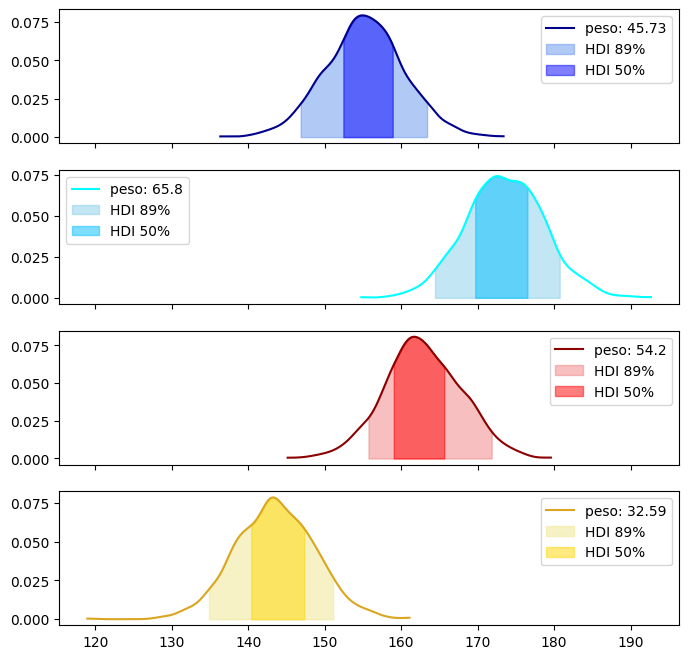

In [94]:
y_ppc = idata.posterior_predictive['altura'].stack(sample=("chain", "draw"))
colores = {'linea': ['darkblue', 'cyan', 'darkred', 'goldenrod'],
           'hdi50': ['blue', 'deepskyblue', 'red', 'gold'],
           'hdi89': ['cornflowerblue', 'skyblue', 'lightcoral', 'khaki']}
fig, ax = plt.subplots(4, 1, sharex=True, figsize=(8, 8))

for i in range(len(pesos)):
    grid, pdf = az.stats.density_utils._kde_linear(y_ppc[i].values)
    hdi89 = az.hdi(y_ppc[i].values, hdi_prob=0.89)
    hdi50 = az.hdi(y_ppc[i].values, hdi_prob=0.50)
    ax[i].plot(grid, pdf, label=f'peso: {pesos[i]}', color=colores['linea'][i])
    ax[i].fill_between(grid, pdf, where=(grid >= hdi89[0]) & (grid <= hdi89[1]), alpha=0.5, label='HDI 89%', color=colores['hdi89'][i])
    ax[i].fill_between(grid, pdf, where=(grid >= hdi50[0]) & (grid <= hdi50[1]), alpha=0.5, label='HDI 50%', color=colores['hdi50'][i])
    ax[i].legend();

# 6.
Repita el punto 4 pero para los menores de 18 años. Exponga los resultados.

In [12]:
howell = pd.read_csv('../datos/howell.csv', sep=';')
howell.head()

,altura,peso,edad,sexo
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [100]:
modelo_howell = bmb.Model("altura ~ peso", howell)

In [101]:
idata = modelo_howell.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [altura_sigma, Intercept, peso]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 33 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


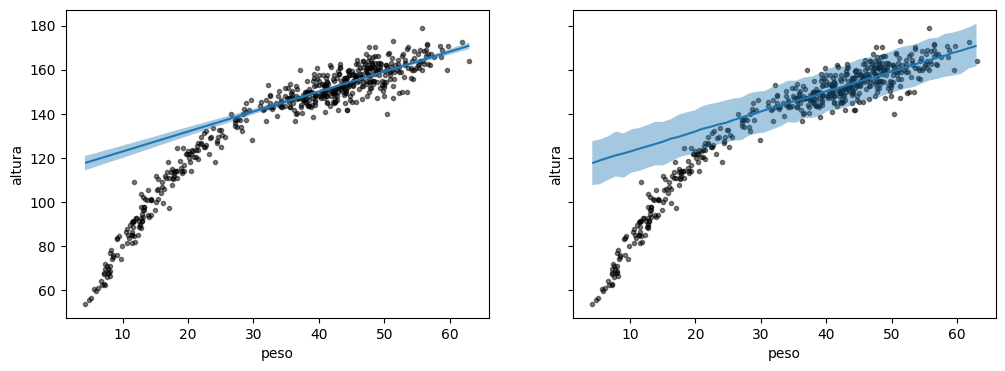

In [99]:
_, axes = plt.subplots(1, 2, sharey=True, figsize=(12, 4))
bmb.interpret.plot_predictions(modelo_howell, idata, 'peso', ax=axes[0])
bmb.interpret.plot_predictions(modelo_howell, idata, 'peso', pps=True, ax=axes[1])

axes[0].plot(howell['peso'], howell['altura'], '.', color='black', alpha=0.5, zorder=-1)
axes[1].plot(howell['peso'], howell['altura'], '.', color='black', alpha=0.5, zorder=-1);

Claramente hay que cambiar algo, por ejemplo hacerlo polinomico

In [22]:
modelo_howell = bmb.Model("altura ~ poly(peso, degree=2)", howell)
modelo_howell

       Formula: altura ~ poly(peso, degree=2)
        Family: gaussian
          Link: mu = identity
  Observations: 544
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 138.2636, sigma: 68.9427)
            poly(peso, degree=2) ~ Normal(mu: [0. 0.], sigma: [1608.0055 1608.0055])
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 27.5771)

In [23]:
idata = modelo_howell.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [altura_sigma, Intercept, poly(peso, degree=2)]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 20 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


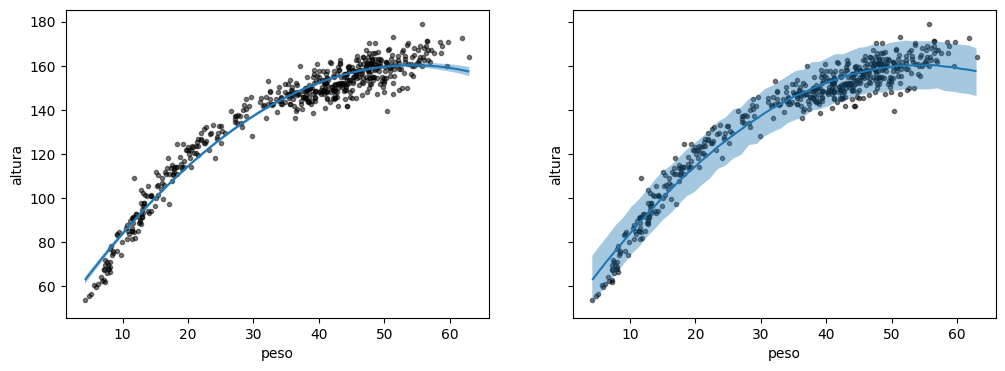

In [24]:
_, axes = plt.subplots(1, 2, sharey=True, figsize=(12, 4))
bmb.interpret.plot_predictions(modelo_howell, idata, 'peso', ax=axes[0])
bmb.interpret.plot_predictions(modelo_howell, idata, 'peso', pps=True, ax=axes[1])

axes[0].plot(howell['peso'], howell['altura'], '.', color='black', alpha=0.5, zorder=-1)
axes[1].plot(howell['peso'], howell['altura'], '.', color='black', alpha=0.5, zorder=-1);

# 7.
Use el modelo ``modelo_bl`` pero aplicada al conjunto de datos iris. Intente clasificar setosa o versicolor en función de ``sepal_length``. ¿Cuán útil es este modelo comparado con una regresión logística?

In [147]:
iris = pd.read_csv('../datos/iris.csv')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [151]:
iris = iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(iris['species']).codes

In [153]:
with pm.Model() as modelo_bl:
    α = pm.Normal('α', mu=0, sigma=100)
    β = pm.Normal('β', mu=0, sigma=10)
    σ = pm.HalfCauchy('σ', 10)
    μ = pm.Deterministic('μ', α + β * iris.sepal_length)
    _ = pm.Normal('y_pred', mu=μ, sigma=σ, observed=y_0)

In [154]:
with modelo_bl:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [α, β, σ]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 29 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


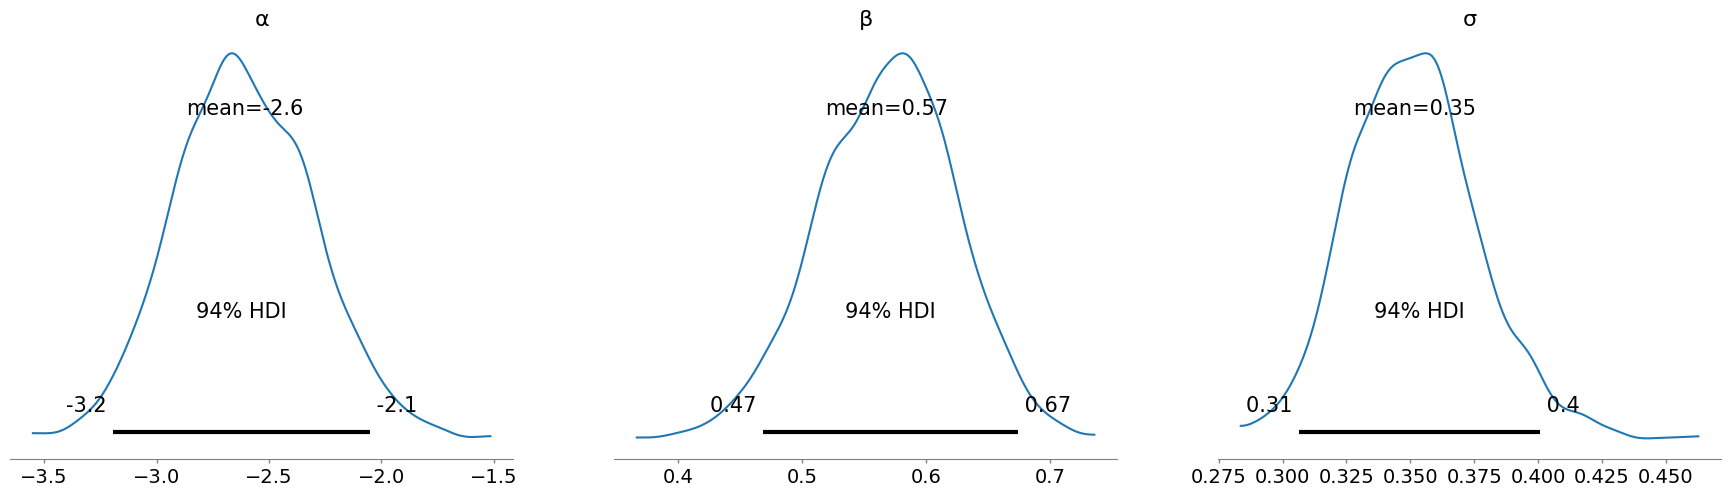

In [157]:
az.plot_posterior(idata, var_names=['α', 'β', 'σ']);

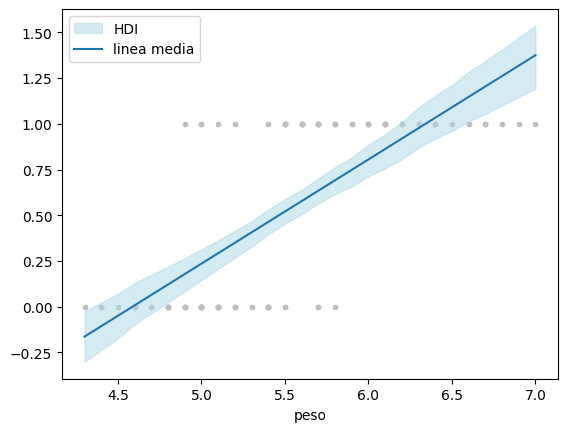

In [161]:
posterior = az.extract(idata, num_samples=50)
x_plot = xr.DataArray(np.linspace(iris.sepal_length.min(), iris.sepal_length.max(), 50), dims="plot_id")
linea_media = posterior['α'].mean() + posterior['β'].mean() * x_plot
hdi_lines = az.hdi(idata.posterior['μ'])


plt.plot(iris.sepal_length, y_0, '.', color="0.75",  zorder=-3)
idx = np.argsort(iris.sepal_length.values)
plt.fill_between(iris.sepal_length.sort_values(), hdi_lines["μ"][:,0][idx], hdi_lines["μ"][:,1][idx],
                     color="lightblue", label='HDI', alpha=0.5)
plt.plot(x_plot, linea_media, c='C0', label='linea media')
plt.xlabel('sepal_length')
plt.legend();

Al no tener una función de enlace que transforme los valores al rango (0, 1) la probabilidad de pertenecer a la clase 1 puede tomar valores por encima y por debajo de dicho intervalo, esto me dice que hay algo mal con la logica del modelo.  
Más allá de eso debería ser capaz de elegir un umbral para clasificar, seguramente no sería óptimo.

# 8.
Vuelva a correr el ``modelo_rl`` pero esta vez usando la variable ``petal_width`` ¿En que difieren los resultados? ¿Cuán ancho o angosto es el intervalo HDI 94%?

In [167]:
iris = pd.read_csv('../datos/iris.csv')
df = iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(df['species']).codes
x_n = 'petal_width'
x_0 = df[x_n].values
x_c = x_0 - x_0.mean()

In [168]:
with pm.Model() as modelo_rl:
    α = pm.Normal('α', mu=0, sigma=1)
    β = pm.Normal('β', mu=0, sigma=5)
    
    μ = α + β * x_c   
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    bd = pm.Deterministic('bd', -α/β)
    
    yl = pm.Bernoulli('yl', p=θ, observed=y_0)

    idata_rl = pm.sample(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [α, β]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 40 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [169]:
az.summary(idata_rl, var_names='~θ')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bd,-0.021,0.062,-0.135,0.093,0.002,0.001,1708.0,1377.0,1.0
α,0.223,0.699,-1.084,1.525,0.017,0.015,1659.0,1399.0,1.0
β,11.460,2.464,7.066,15.900,0.073,0.053,1230.0,1058.0,1.0


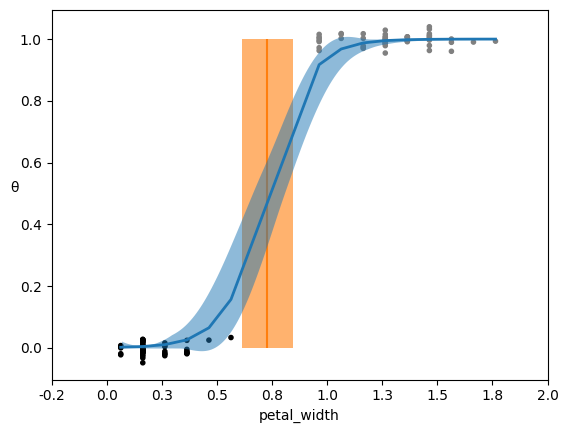

In [174]:
posterior = idata_rl.posterior
theta = posterior["θ"].mean(("chain", "draw"))
idx = np.argsort(x_c)

_, ax = plt.subplots()

ax.plot(x_c[idx], theta[idx], color='C0', lw=2)
ax.vlines(posterior['bd'].mean(("chain", "draw")), 0, 1, color='C1', zorder=0)
bd_hdi = az.hdi(posterior['bd'])
ax.fill_betweenx([0, 1], bd_hdi["bd"][0], bd_hdi["bd"][1], color='C1', alpha=0.6, lw=0)
ax.scatter(x_c, np.random.normal(y_0, 0.02), marker='.', color=[f'{0.5*x}' for x in y_0])
az.plot_hdi(x_c, posterior['θ'], color='C0', ax=ax, fill_kwargs={"lw": 0})
ax.set_xlabel(x_n)
ax.set_ylabel('θ', rotation=0)
# usar escala original para los xticks
locs, _ = plt.xticks()
ax.set_xticks(locs, np.round(locs + x_0.mean(), 1));

Este modelo divide mejor a las especies que el anterior y el ancho del hdi del umbral es lo suficiente angosto como para que no haya ninguna observación que caiga dentro, esto quiere decir que estamos bastante seguros de la clasficación que podemos hacer con este modelo.

# 9.
Lea este post y replique los resultados usted mismo.